In [1]:
import os
import cv2
import json
import math
import torch
import numpy as np
import kornia as K
import kornia.feature as KF
from vidstab import VidStab
import matplotlib.pyplot as plt

from lightglue import viz2d
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd, load_image_from_path
import CSRansac

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
#matcher = LightGlue(features='superpoint', depth_confidence=0.9, width_confidence=0.95).eval().to(device)
matcher = LightGlue(features='superpoint', depth_confidence=-1, width_confidence=-1).eval().to(device)
#matcher.compile(mode='reduce-overhead')

In [4]:
print(torch.__version__)
print(device)

2.1.2
cuda


In [5]:
stabilizer = VidStab()


def match_lightglue(img0, img1):
    img0 = load_image(img0)
    img1 = load_image(img1)

    # extract local features
    feats0 = extractor.extract(img0.to(device))  # auto-resize the image, disable with resize=None
    feats1 = extractor.extract(img1.to(device))
    
    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
    
    # get results
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = kpts0[matches[..., 0]]  # coordinates in img0, shape (K,2)
    points1 = kpts1[matches[..., 1]]  # coordinates in img1, shape (K,2)
        
    return {
        "points0": points0,
        "points1": points1,
    }
    

def matching_keypoints(target_img, video_img, stabilizing=False):
    # 이미지를 불러옴
    img0 = load_image(target_img, grayscale=True)
    if stabilizing == True:
        img1 = cv2.imread(video_img)
        img1 = stabilizer.stabilize_frame(img1)
        img1 = load_image(img1, grayscale=True)
    else:
        img1 = load_image(video_img , grayscale=True)

    # extract local features
    feats0 = extractor.extract(img0.to(device))  # auto-resize the image, disable with resize=None
    feats1 = extractor.extract(img1.to(device))

    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

    # get results
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = kpts0[matches[..., 0]]  # coordinates in img0, shape (K,2)
    points1 = kpts1[matches[..., 1]]  # coordinates in img1, shape (K,2)

    return {
        "points0": points0,
        "points1": points1,
    }    
  
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (640, 480))  # 필요한 경우 이미지 크기 조정
    image = K.image_to_tensor(image, False).float() / 255.0
    image = image.to(device)
    return image

# def get_errors(coord_list, float_origin_coordinate, len_coord):
#     misannotate_error = 0
#     pixel_error = 0
    
#     for i in range(len_coord):
#         origin_x = float_origin_coordinate[i][0]
#         origin_y = float_origin_coordinate[i][1]
        
#         for j in range(len(coord_list[i])-1):
#             _coord = coord_list[i][j]
            
#             x = _coord[0][0]
#             y = _coord[0][1]
            
#             x = x / 640
#             y = y / 480
            
#             x = round(x, 4)
#             y = round(y, 4)
            
#             # disappear_error
#             # if x < 0 or x > 1 or y < 0 or y > 1:
#             #     disappear_error += 1
            
#             distance = math.sqrt((origin_x - x)**2 + (origin_y - y)**2)
            
#             # num_error
#             if distance > 0.1:
#                 misannotate_error += 1
            
#             # pixel_error
#             if distance > pixel_error:
#                 pixel_error = distance
                
#     return misannotate_error, pixel_error

## Dataset 전처리

In [3]:
aircraft_datasets = "D:/AMARA/"

labels = os.path.join(aircraft_datasets, "label")
video_dir = os.path.join(aircraft_datasets, "video")
target_image_dir = os.path.join(aircraft_datasets, "image")
output_dir = os.path.join(aircraft_datasets, "frames_from_video")

In [7]:
origin_coordinate = []

# 원점 좌표값 불러오기
for label_file in os.listdir(labels):
    label_path = os.path.join(labels, label_file)
    with open(label_path, "r") as f:
        json_file = json.load(f)
        coord = json_file["targetAnnotation"]
        coord[0] = coord[0] * 640
        coord[1] = coord[1] * 480
        origin_coordinate.append(coord)

print(origin_coordinate)
print(len(origin_coordinate))


[[319.171968, 270.55248], [320.0, 265.24536], [344.464896, 256.02912], [313.576128, 257.29579199999995], [325.48172800000003, 168.083808], [315.939648, 202.48910399999997], [325.479232, 168.080352], [312.391232, 306.426768], [320.0, 265.23864], [331.487168, 26.902847999999988], [316.5232, 203.087808], [329.47750399999995, 59.02296000000001], [320.0, 337.57583999999997], [324.136448, 161.35992000000002], [309.34656, 253.744368], [321.263104, 248.872656], [332.852352, 236.02262399999998], [326.04812799999996, 203.801712], [318.48947200000003, 251.060496], [320.964672, 255.825552], [321.25523200000003, 215.70609599999997], [319.453312, 225.751632], [319.45344, 180.868992], [321.200512, 215.63779200000002], [321.227712, 215.671728], [316.37516800000003, 230.084016], [316.20556799999997, 231.432768], [320.89824, 312.286224], [320.950912, 198.62135999999998], [315.928128, 231.49977600000003], [320.895168, 257.614128], [320.82163199999997, 257.47713600000003], [320.820608, 257.477952], [320.6

In [8]:
# 원본 이미지 경로를 저장할 리스트
images = [[] for i in range(len(origin_coordinate))]
i = 0

# output_dir 내의 모든 폴더에 대한 반복
for folder_name in os.listdir(output_dir):
    folder_path = os.path.join(output_dir, folder_name)
    
    for name in os.listdir(folder_path):
        filename = os.path.join(folder_path, name)
        images[i].append(filename)
    
    i = i + 1

# images 리스트의 길이 반환
# num_images = len(images)
# print(f"총 이미지 수: {num_images}")

print(len(images[0]))

368


## 프레임 -> 비디오로 변환하는 코드

In [3]:
import cv2 
import os

def images_to_video(image_folder, video_name):
    # 이미지 파일 목록 가져오기
    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg") or img.endswith(".png")]
    images.sort()  # 파일 이름 순으로 정렬

    # 첫 번째 이미지에서 프레임 크기 가져오기
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    # VideoWriter 객체 생성
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')  # 코덱 설정
    video = cv2.VideoWriter(video_name, fourcc, 30, (width, height))

    for image in images:
        img_path = os.path.join(image_folder, image)
        frame = cv2.imread(img_path)
        video.write(frame)  # 프레임 추가

    video.release()  # 동영상 파일 저장

# 예제 사용법
image_folder = 'stable_video/'  # 이미지들이 저장된 폴더 경로
video_name = 'demo_video_stable_resized.mp4'  # 저장할 동영상 파일 이름
fps = 30  # 초당 프레임 수

images_to_video(image_folder, video_name)


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


## 비디오 -> 프레임으로 변환하는 코드

In [28]:
# #동영상에서 각 프레임을 이미지 파일로 저장하는 코드
# if not os.path.exists(os.path.join(aircraft_datasets + 'frames_from_video')):
#     os.makedirs(os.path.join(aircraft_datasets + 'frames_from_video'))
    
# videos = os.listdir(video_dir)

# frame_paths = []     

# for video in videos:
#     # 동영상 파일 로드
#     video_path = os.path.join(video_dir, video)
#     frame_path = os.path.join(aircraft_datasets + 'frames_from_video/', video.split('.')[0])
#     video = cv2.VideoCapture(os.path.join(video_dir, video))
    
#     frame_paths.append(frame_path)

#     # 프레임 카운터 초기화
#     frame_count = 0

#     while True:
#         # 동영상에서 프레임을 읽음
#         ret, frame = video.read()
#         if not ret:
#             break  # 동영상 끝에 도달하면 중단
        
#         # 프레임을 이미지 파일로 저장
#         if not os.path.exists(frame_path):
#             os.makedirs(frame_path)
#         frame_filename = os.path.join(frame_path + '/' + f'frame_{frame_count:04d}.jpg')
#         frame = cv2.resize(frame, (640, 480))
#         cv2.imwrite(frame_filename, frame)
        
#         frame_count += 1

#     # 자원 해제
#     video.release()

## 영상 type에 따라서 비디오를 분류함

In [36]:
# import shutil

# _frame_paths = frame_paths.copy()
     
# for i in range(5):
#     length = len(_frame_paths)
    
#     destination = os.path.join(aircraft_datasets + 'frames_from_video/', f'video_{i + 1}')
    
#     if not os.path.exists(destination):
#         os.makedirs(destination)
        
#     for j in range(length):
#         if _frame_paths[j][-1] == str(i + 1):
#             try:
#                 shutil.move(_frame_paths[j], destination)
#             except:
#                 continue

In [39]:
import shutil

label_path = []

for label_file in os.listdir(labels):
    label_path.append(os.path.join(labels, label_file))
    
_label_path = label_path.copy()
     
for i in range(5):
    length = len(_label_path)
    
    destination = os.path.join(aircraft_datasets + 'label/', f'lable_{i + 1}')
    
    if not os.path.exists(destination):
        os.makedirs(destination)
        
    for j in range(length):
        if _label_path[j].split('.')[0][-1] == str(i + 1):
            try:
                shutil.move(_label_path[j], destination)
            except:
                continue

In [5]:
import shutil

image_path = []

for image_file in os.listdir(target_image_dir):
    image_path.append(os.path.join(target_image_dir, image_file))
    
_image_path = image_path.copy()
     
for i in range(5):
    length = len(_image_path)
    
    destination = os.path.join(aircraft_datasets + 'image/', f'lable_{i + 1}')
    
    if not os.path.exists(destination):
        os.makedirs(destination)
        
    for j in range(length):
        if _image_path[j].split('.')[0][-1] == str(i + 1):
            try:
                shutil.move(_image_path[j], destination)
            except:
                continue

## 어노테이션 후 동영상으로 저장하는 코드

In [14]:
cap = cv2.VideoCapture('D:/aircraft_datasets/video/FuelPumpRemoval_00011.mp4')

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('FuelPumpRemoval_00011.mp4', fourcc, 30, (640, 480))


_images = images[10]
_len_images = len(_images)
x = origin_coordinate[10][0]
y = origin_coordinate[10][1]

img0 = _images[0] # 첫 번째 이미지를 target 이미지로 설정
for j in range(_len_images):
    if j == 0:
        continue
    
    img1 = _images[j]
    _img1 = cv2.imread(img1)

    # LightGlue
    results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
    target_keypoint = results_lightglue["points0"].cpu().numpy()
    frame_keypoint = results_lightglue["points1"].cpu().numpy()

    homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
    projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)
    
    img0 = img1
    
    cv2.circle(_img1, (int(projected_pts[0]), int(projected_pts[1])), 15, (0, 0, 255), -1)
    cv2.circle(_img1, (int(projected_pts[0]), int(projected_pts[1])), 3, (255, 255, 255), -1)
    cv2.imshow('frame', _img1)
    
    out.write(_img1)
    
    key = cv2.waitKey(5)
    if key == 27:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()
            

In [9]:
cap = cv2.VideoCapture('demo_video_resized.mp4')

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('demo_video_resized_annotated.mp4', fourcc, 30, (640, 480))


x = 637 / 2
y = 367 / 2

img0 = cv2.imread('img0.png')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img1 = frame

    # LightGlue
    results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
    target_keypoint = results_lightglue["points0"].cpu().numpy()
    frame_keypoint = results_lightglue["points1"].cpu().numpy()

    homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
    projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)
    
    img0 = img1
    
    cv2.circle(img1, (int(projected_pts[0]), int(projected_pts[1])), 15, (0, 0, 255), -1)
    cv2.circle(img1, (int(projected_pts[0]), int(projected_pts[1])), 3, (0, 0, 0), -1)
    #cv2.imshow('frame', _img1)
    
    out.write(img1)
    
    key = cv2.waitKey(5)
    if key == 27:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()
            

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


NameError: name 'extractor' is not defined

## 안정화 알고리즘

In [9]:
cap = cv2.VideoCapture('demo_video_stable_resized.mp4')

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('demo_video_resized_annotated.mp4', fourcc, 30, (640, 480))

stable_inlier_rates = []

x = 637 / 2
y = 367 / 2

img0 = cv2.imread('img0.png')

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    img1 = frame

    # LightGlue
    results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
    target_keypoint = results_lightglue["points0"].cpu().numpy()
    frame_keypoint = results_lightglue["points1"].cpu().numpy()

    homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
    projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)
    
    stable_inlier_rates.append(mask)
    
    img0 = img1
        
    # cv2.circle(img1, (int(projected_pts[0]), int(projected_pts[1])), 15, (0, 0, 255), -1)
    # cv2.circle(img1, (int(projected_pts[0]), int(projected_pts[1])), 3, (0, 0, 0), -1)
    # #cv2.imshow('frame', _img1)
    
    # out.write(img1)
    
    key = cv2.waitKey(5)
    if key == 27:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()  

In [10]:
# inlier rate 저장
print(stable_inlier_rates)

[0.938671209540034, 0.9975354282193469, 0.9607712765957447, 0.9609164420485176, 0.9728813559322034, 0.9450474898236092, 0.8708771929824561, 0.9993011879804332, 0.980013783597519, 0.9992962702322308, 0.7869955156950673, 0.9968304278922345, 0.9667590027700831, 0.9893828798938288, 0.9898648648648649, 0.9575757575757575, 0.9605173587474473, 0.9964387464387464, 0.9020581973030518, 0.9695290858725761, 0.9410050983248361, 0.9939255884586181, 0.9991967871485944, 0.9240924092409241, 0.977645305514158, 0.995965030262273, 0.9959677419354839, 0.9979647218453188, 0.9986320109439124, 0.9887323943661972, 0.8261834319526628, 0.9583632447954056, 0.9985569985569985, 0.9969301611665388, 0.9534522885958107, 0.9866875489428347, 0.9652173913043478, 0.9955385595920969, 0.9915639195327709, 0.9633267845448592, 0.9993315508021391, 0.8976063829787234, 0.9951590594744122, 0.999344262295082, 0.9505154639175257, 0.9525471039776692, 0.7704117236566643, 0.9642090193271295, 0.8653366583541147, 0.9161793372319688, 0.83

## 광학 추적 + 칼만 필터

In [14]:
# 칼만 필터 초기화
kalman = cv2.KalmanFilter(8, 4)
kalman.measurementMatrix = np.eye(4, 8, dtype=np.float32)
kalman.transitionMatrix = np.eye(8, dtype=np.float32)
kalman.processNoiseCov = np.eye(8, dtype=np.float32) * 0.01
kalman.measurementNoiseCov = np.eye(4, dtype=np.float32) * 0.1
kalman.errorCovPost = np.eye(8, dtype=np.float32)

optical_flow_inlier_rates = [] 


# Lucas-Kanade optical flow 파라미터
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

cap = cv2.VideoCapture('demo_video_resized.mp4')

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('demo_video_optical_resized_annotated.mp4', fourcc, 30, (640, 480))


x = 637 / 2
y = 367 / 2

# LoFTR 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loftr = KF.LoFTR(pretrained='outdoor').to(device)

image_path = 'img0.png'
image = load_and_preprocess_image(image_path)
prev_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 특징점 추출
with torch.no_grad():
    input_dict = {"image0": image, "image1": image}
    correspondences = loftr(input_dict)

# 특징점 시각화
prev_points = correspondences['keypoints0'].cpu().numpy()
prev_points = prev_points.reshape(-1, 1, 2)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img1 = frame
    
    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    next_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None, **lk_params)
    good_old = prev_points[status == 1]
    good_new = next_points[status == 1]

    if len(good_new) >= 4:
        H, mask = cv2.findHomography(good_old, good_new, cv2.RANSAC, 5.0)
            
        if H is not None:
            inliers = mask.ravel().tolist().count(1)
            total_points = len(mask)
            inlier_rate = inliers / total_points
            optical_flow_inlier_rates.append(inlier_rate)
            
            # 원본 이미지의 좌표를 변환
            points = np.array([[x, y]], dtype='float32')
            projected_points = cv2.perspectiveTransform(np.array([points]), H)
            # 칼만 필터 업데이트
            measured = np.array([[projected_points[0][0][0], projected_points[0][0][1], 0, 0]], dtype=np.float32).T
            kalman.correct(measured)
            prediction = kalman.predict()
            
            cv2.circle(img1, (int(prediction[0][0]), int(prediction[1][0])), 15, (0, 0, 255), -1)
            cv2.circle(img1, (int(prediction[0][0]), int(prediction[1][0])), 3, (0, 0, 0), -1)
    
    prev_gray = gray
    prev_points = good_new.reshape(-1, 1, 2)
    
    
    out.write(img1)
    
    key = cv2.waitKey(5)
    if key == 27:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows() 

In [35]:
print(origin_coordinate[10])
print(origin_coordinate[36])

[316.5232, 203.087808]
[320.0, 257.736]


In [12]:
# 칼만 필터 초기화
kalman = cv2.KalmanFilter(8, 4)
kalman.measurementMatrix = np.eye(4, 8, dtype=np.float32)
kalman.transitionMatrix = np.eye(8, dtype=np.float32)
kalman.processNoiseCov = np.eye(8, dtype=np.float32) * 0.01
kalman.measurementNoiseCov = np.eye(4, dtype=np.float32) * 0.1
kalman.errorCovPost = np.eye(8, dtype=np.float32)

optical_flow_inlier_rates = [] 


# Lucas-Kanade optical flow 파라미터
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

cap = cv2.VideoCapture('WheelAndTireAssemblyRemoval_00007.mp4')

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('optical_WheelAndTireAssemblyRemoval_00007.mp4', fourcc, 30, (640, 480))


x = 320.0
y = 257.736

# LoFTR 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loftr = KF.LoFTR(pretrained='outdoor').to(device)

image_path = 'WheelAndTireAssemblyRemoval_00007.jpg'
image = load_and_preprocess_image(image_path)
prev_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 특징점 추출
with torch.no_grad():
    input_dict = {"image0": image, "image1": image}
    correspondences = loftr(input_dict)

prev_points = correspondences['keypoints0'].cpu().numpy()
prev_points = prev_points.reshape(-1, 1, 2)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img1 = frame
    img1 = cv2.resize(img1, (640, 480))
    
    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    next_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None, **lk_params)
    good_old = prev_points[status == 1]
    good_new = next_points[status == 1]

    if len(good_new) >= 4:
        H, mask = cv2.findHomography(good_old, good_new, cv2.RANSAC, 5.0)
            
        if H is not None:
            inliers = mask.ravel().tolist().count(1)
            total_points = len(mask)
            inlier_rate = inliers / total_points
            optical_flow_inlier_rates.append(inlier_rate)
            
            # 원본 이미지의 좌표를 변환
            points = np.array([[x, y]], dtype='float32')
            projected_points = cv2.perspectiveTransform(np.array([points]), H)
            # 칼만 필터 업데이트
            measured = np.array([[projected_points[0][0][0], projected_points[0][0][1], 0, 0]], dtype=np.float32).T
            kalman.correct(measured)
            prediction = kalman.predict()
            
            cv2.circle(img1, (int(prediction[0][0]), int(prediction[1][0])), 15, (0, 0, 255), -1)
            cv2.circle(img1, (int(prediction[0][0]), int(prediction[1][0])), 3, (0, 0, 0), -1)
            print(prediction[0][0], prediction[1][0])
            
    prev_gray = gray
    prev_points = good_new.reshape(-1, 1, 2)
    
    
    out.write(img1)
    
    key = cv2.waitKey(5)
    if key == 27:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows() 

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


0.0 0.0
29.01332 23.428587
75.52724 60.990788
125.85594 101.62654
171.23418 138.25137
208.33984 168.20424
237.14296 191.44838
258.86002 208.98277
274.99152 222.002
286.88248 231.59308
295.6105 238.621
301.98813 243.7696
306.6649 247.53659
310.0663 250.29105
312.56152 252.2975
314.38382 253.75421
315.71503 254.81967
316.6755 255.59105
317.40424 256.1546
317.91425 256.57394
318.29047 256.87228
318.57175 257.09396
318.7881 257.26053
318.93243 257.36768
319.0362 257.4579
319.11737 257.50797
319.17892 257.557
319.22507 257.58438
319.25473 257.60596
319.27423 257.62158
319.29547 257.63828
319.3077 257.6356
319.32037 257.64023
319.33087 257.64352
319.3405 257.65247
319.34793 257.65125
319.34827 257.6464
319.36108 257.65176
319.3646 257.65414
319.367 257.64764
319.37308 257.6443
319.37253 257.64832
319.38486 257.6492
319.38864 257.65213
319.3817 257.65482
319.38663 257.65588
319.38132 257.66104
319.38623 257.6618
319.39624 257.67426
319.39172 257.66797
319.40643 257.6776
319.40536 257.68
319.4

In [15]:
# inlier rate 저장
print(optical_flow_inlier_rates)

[0.9508149842722333, 0.9839830764581444, 0.9939471169162154, 0.9447351209941138, 0.9950166112956811, 0.9943200801871033, 0.9914617486338798, 0.976223294279807, 0.9860869565217392, 0.9891608391608392, 0.9953998584571833, 0.8622412562455389, 0.9960374639769453, 0.9873737373737373, 0.9909189974573193, 0.9923469387755102, 0.9941370465371931, 0.9959603378626515, 0.9963072378138847, 0.9970282317979198, 0.9947447447447447, 0.9616397141782626, 0.8238636363636364, 0.9494296577946768, 0.9984761904761905, 0.9862332695984704, 0.9635456638526477, 0.9845916795069337, 0.9895145631067961, 0.985603112840467, 0.9941360437842064, 0.9952774498229043, 0.9588932806324111, 0.9944444444444445, 0.9916201117318436, 0.9975932611311673, 0.9677809101892871, 0.9971740008074284, 0.9971602434077079, 0.9975609756097561, 0.995508370763577, 0.9930242100943784, 0.9979296066252588, 0.9995838535164377, 0.9874424445374633, 0.9518425460636516, 0.9692890197728229, 0.9995785924989464, 0.9987336428872943, 0.9983100971694128, 0.

## Inlier rate 그래프 그리기

In [ ]:
#원본 이미지를 기준으로 호모그래피 행렬을 구하고, 호모그래피 행렬을 이용하여 특징점의 좌표를 변환하는 코드
epochs = 2

for index in range(0, 5):
    # 각종 평가 수치들
    misannotate_errors = []
    pixel_errors = []
    failed_inliers = 0
    zero_inliers = 0
    inlier_rates = 0
    
    len_coord = len(origin_coordinates[index])
    coord_list = [[] for _i in range(len(origin_coordinates[index]))]
    
    # 10번 반복하여 측정한 에러를 구함
    for k in range(epochs):
        # 좌표의 개수(동영상의 개수)만큼 반복
        for i in range(len_coord):
            _images = images[index][i]
            _len_images = len(_images)
            
            x = origin_coordinates[index][i][0]
            y = origin_coordinates[index][i][1]
            
            # 두 번째 차원의 리스트 초기화
            coord_list[i] = [[] for _ in range(_len_images)]

            img0 = _images[0] # 첫 번째 이미지를 target 이미지로 설정
            
            for j in range(_len_images):
                if j != _len_images - 1:
                    img1 = _images[j+1]

                    # LightGlue
                    results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
                    target_keypoint = results_lightglue["points0"].cpu().numpy()
                    frame_keypoint = results_lightglue["points1"].cpu().numpy()
                    if len(target_keypoint) < 6:
                        failed_inliers += 1
                        continue

                    homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
                    if mask <= 0.3:
                        if mask == 0:
                            zero_inliers += 1
                        failed_inliers += 1
                    
                    inlier_rates += mask
                    projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)

                    coord_list[i][j].append(projected_pts)
                    
                    img0 = img1
                    x = projected_pts[0]
                    y = projected_pts[1]
                    
        #에러 측정            
        # disappear_error = 0
        misannotate_error, pixel_error = get_errors(coord_list, float_origin_coordinates[index], len_coord)
                
        #print("disappear_error:", disappear_error)
        misannotate_errors.append(misannotate_error)
        pixel_errors.append(pixel_error)
        
    
    
    error1 = sum(misannotate_errors) / len(misannotate_errors)
    error2 = sum(pixel_errors) / len(pixel_errors)
    error3 = inlier_rates / (len(lengths[index]) * epochs)

    print("failed_inliers:", failed_inliers)
    print("zero_inliers:", zero_inliers)
    print("misannotate_error:", error1)
    print("pixel_error:", error2)
    print("inlier_rate:", error3)
    print()

In [3]:
stable_inlier_rates = [0.938671209540034, 0.9975354282193469, 0.9607712765957447, 0.9609164420485176, 0.9728813559322034, 0.9450474898236092, 0.8708771929824561, 0.9993011879804332, 0.980013783597519, 0.9992962702322308, 0.7869955156950673, 0.9968304278922345, 0.9667590027700831, 0.9893828798938288, 0.9898648648648649, 0.9575757575757575, 0.9605173587474473, 0.9964387464387464, 0.9020581973030518, 0.9695290858725761, 0.9410050983248361, 0.9939255884586181, 0.9991967871485944, 0.9240924092409241, 0.977645305514158, 0.995965030262273, 0.9959677419354839, 0.9979647218453188, 0.9986320109439124, 0.9887323943661972, 0.8261834319526628, 0.9583632447954056, 0.9985569985569985, 0.9969301611665388, 0.9534522885958107, 0.9866875489428347, 0.9652173913043478, 0.9955385595920969, 0.9915639195327709, 0.9633267845448592, 0.9993315508021391, 0.8976063829787234, 0.9951590594744122, 0.999344262295082, 0.9505154639175257, 0.9525471039776692, 0.7704117236566643, 0.9642090193271295, 0.8653366583541147, 0.9161793372319688, 0.8378033205619413, 0.9993523316062176, 0.9683053040103493, 0.9174983366600133, 0.9859060402684564, 0.9526707234617985, 0.896112600536193, 0.9875086745315753, 0.8787666433076384, 0.9889867841409692, 0.9314888010540184, 0.9987413467589679, 0.9993658845909955, 0.9993690851735015, 0.9080906148867314, 0.9515593895155939, 0.9554054054054054, 0.9933288859239493, 0.9835390946502057, 0.9958534899792675, 0.23390557939914164, 0.9946768060836502, 0.8673469387755102, 0.9809523809523809, 0.9172185430463576, 0.9993373094764745, 0.9907468605419696, 0.9973226238286479, 0.9508867667121419, 0.9834765366820886, 0.998589562764457, 0.9033210332103321, 0.9444866920152091, 0.9877394636015325, 0.9753246753246754, 0.9182630906768838, 0.9888597640891219, 0.9699346405228758, 0.9806763285024155, 0.9238095238095239, 0.978030303030303, 0.967828418230563, 0.8111346018322763, 0.9850634802091113, 0.9533386967015286, 0.8440207972270364, 0.8480801335559266, 0.9800960878517502, 0.9285714285714286, 0.9862542955326461, 0.7734159779614325, 0.8467514124293786, 0.9948529411764706, 0.933283914010378, 0.9943865276663993, 0.9794069192751236, 0.992091388400703, 0.9679376083188909, 0.8836858006042296, 0.8981723237597912, 0.9613297150610584, 0.9924294562973159, 0.8523936170212766, 0.9621472814865795, 0.9737387698686939, 0.956343792633015, 0.8778571428571429, 0.9359939759036144, 0.9414032382420972, 0.9967974379503602, 0.9184549356223176, 0.9245880861850444, -1, 0.8992898644286637, 0.8702633269107257, -1, 0.5903859174001355, 0.9838601210490922, 0.6180836707152496, 0.9745478901540523, 0.9387895460797799, 0.9901408450704225, 0.9671931956257594, 0.9993761696818465, 0.9967553536664504, 0.9868680236375574, 0.9513477975016437, 0.9960681520314548, 0.9993265993265993, 0.9931129476584022, 0.8135935397039031, 0.9907100199071002, 0.9356999330207636, 0.9617834394904459, 0.9695193434935522, 0.9864341085271318, 0.9548678272082527, 0.9784031413612565, 0.9057350032959789, 0.9268947015425889, 0.8980190755685987, 0.917004048582996, 0.9435261707988981, 0.9951083158630328, 0.997169143665959, 0.8357664233576643, 0.9833759590792839, 0.9986789960369881, 0.7369439071566731, 0.8645833333333334, 0.6022727272727273, 0.326072157930565, 0.8649932157394844, 0.9896836313617606, 0.9993288590604027, 0.9790681971640783, 0.9993131868131868, 0.9209597741707833, 0.9528415961305925, 0.9993610223642172, 0.9967679379444085, 0.9907894736842106, 0.9940828402366864, 0.9814200398142005, 0.968358602504944, 0.9820598006644519, 0.9102564102564102, 0.9897540983606558, 0.8692676249144422, 0.8463726884779517, 0.9887076537013801, 0.9943324937027708, 0.9935442220787605, 0.9968982630272953, 0.25598991172761665, 0.9302481556002683, 0.9939959973315544, 0.9831536388140162, 0.994572591587517, 0.9858012170385395, 0.6113387978142076, 0.997920997920998, 0.9503184713375796, 0.9993548387096775, 0.9548678272082527, 0.9940476190476191, 0.9814937210839392, 0.9817813765182186, 0.9467731204258151, 0.9601593625498008, 0.9979550102249489, 0.89553264604811, 0.937455579246624, 0.9440459110473458, 0.9604221635883905, 0.9536082474226805, 0.9634703196347032, 0.9324055666003976, 0.964405641370047, 0.9389830508474576, 0.9832605531295487, 0.9711215580926796, 0.9869055823569952, 0.9978245105148659, 0.29429429429429427, 0.9255398361876396, 0.971830985915493, 0.9949012109623965, 0.8804990151017729, 0.9980106100795756, 0.8896276595744681, 0.93812375249501, 0.9965870307167235, 0.9973457199734572, 0.8897158322056834, 0.9811066126855601, 0.9979591836734694, 0.8086330935251799, 0.9864864864864865, 0.9556119213696893, -1, 0.9110085695451549, 0.9385327164573695, 0.9313593539703903, 0.869031377899045, 0.9993164730006835, 0.9993252361673415, 0.9965421853388658, 0.9993112947658402, 0.982806052269601, 0.9485294117647058, 0.8671373555840821, 0.9908616187989556, 0.9746258945998699, 0.9993476842791911, 0.9993421052631579, 0.9966009517335146, 0.8980150581793293, 0.9931506849315068, 0.9659318637274549, 0.9979838709677419, 0.957679180887372, 0.9420468557336621, 0.9902024820378837, 0.9914698162729659, 0.9986919555264879, 0.960455764075067, 0.9913850231941683, 0.9513981358189081, 0.8948412698412699, 0.9384203480589023, 0.981542518127884, 0.8733920108327691, 0.9760159893404398, 0.9167657550535078, 0.9948553054662379, 0.953185955786736, 0.9439313984168866, 0.9974408189379399, 0.9929123711340206, -1, 0.818954248366013, 0.970880211780278, 0.9986468200270636, 0.9986693280106453, 0.9292667099286178, 0.9495896834701055, 0.9987285441830897, 0.5915404040404041, 0.8770019218449712, 0.9986979166666666, -1, 0.3610934520025429, 0.9282595134123518, 0.999345977763244, 0.9436258808456118, 0.9776609724047306, 0.9860650298606503, 0.9916467780429594, 0.30340760157273916, 0.9943360604153556, 0.9955442393380013, -1, 0.25048923679060664, 0.9923273657289002, 0.988134475939354, -1, 0.9960291197882197, 0.99, 0.9584728734092431, 0.9547738693467337, 0.9448669201520913, 0.6186440677966102, 0.8010437051532941, 0.9973924380704041, -1, 0.9514824797843666, 0.9434840425531915, 0.9198113207547169, 0.9676113360323887, 0.8572386058981233, 0.9796918767507002, 0.927536231884058, -1, 0.8961713173264114, 0.8877146631439894, 0.9933949801849405, -1, 0.822569680489463, 0.9952830188679245, 0.9659400544959128, 0.9587000677048071, 0.986468200270636, 0.9037800687285223, 0.8576687116564418, 0.9954218443427076, 0.9623621025308241, 0.9562091503267974, 0.999345977763244, 0.8913333333333333, 0.9985507246376811, 0.9020833333333333, 0.9992962702322308, 0.9824442943956786, 0.9324324324324325, 0.9370629370629371, 0.9523212045169385, 0.9987244897959183, 0.9908136482939632, 0.6576338400528751, 0.9980366492146597, 0.37812911725955206, 0.9972972972972973, 0.9828767123287672, 0.9852150537634409, 0.9107883817427386, 0.973433242506812, 0.9929775280898876, 0.8517587939698492, 0.9668578712555768, 0.9771540469973891, 0.9961038961038962, 0.8593852190974494, 0.8089005235602095, 0.9993238674780257, 0.8745762711864407, 0.9227181878747501, 0.940419769803656, 0.9965229485396384, 0.9548022598870056, 0.9824561403508771, 0.9559193954659949, 0.9961464354527938, 0.9986850756081526, 0.9973804846103471, 0.9081153588195842, 0.9973509933774835, -1]
optical_inlier_rates = [0.9508149842722333, 0.9839830764581444, 0.9939471169162154, 0.9447351209941138, 0.9950166112956811, 0.9943200801871033, 0.9914617486338798, 0.976223294279807, 0.9860869565217392, 0.9891608391608392, 0.9953998584571833, 0.8622412562455389, 0.9960374639769453, 0.9873737373737373, 0.9909189974573193, 0.9923469387755102, 0.9941370465371931, 0.9959603378626515, 0.9963072378138847, 0.9970282317979198, 0.9947447447447447, 0.9616397141782626, 0.8238636363636364, 0.9494296577946768, 0.9984761904761905, 0.9862332695984704, 0.9635456638526477, 0.9845916795069337, 0.9895145631067961, 0.985603112840467, 0.9941360437842064, 0.9952774498229043, 0.9588932806324111, 0.9944444444444445, 0.9916201117318436, 0.9975932611311673, 0.9677809101892871, 0.9971740008074284, 0.9971602434077079, 0.9975609756097561, 0.995508370763577, 0.9930242100943784, 0.9979296066252588, 0.9995838535164377, 0.9874424445374633, 0.9518425460636516, 0.9692890197728229, 0.9995785924989464, 0.9987336428872943, 0.9983100971694128, 0.9420228523063902, 0.9978786593126856, 0.9770310506167589, 0.9723168654173765, 0.9987179487179487, 0.9991442019683354, 0.9978503869303526, 0.9969905417024936, 0.9844693701466781, 0.9978411053540587, 0.9831314878892734, 0.9463667820069204, 0.9978336221837089, 0.9952319029042046, 0.9607843137254902, 0.9986888111888111, 0.9960456942003515, 0.9805996472663139, 0.9986666666666667, 0.9991099243435692, 0.9977618621307073, 0.9963947724200091, 0.9986431478968792, 0.9099139882299683, 0.9904458598726115, 0.9931444241316271, 0.9986219568213137, 0.9972311952007383, 0.999536822603057, 0.9781598513011153, 0.959944108057755, 0.9710685954269715, 0.9911048689138576, 0.9990605918271489, 0.9995289684408856, 0.9731385485391141, 0.9957527135441245, 0.9707271010387157, 0.9966793168880456, 0.9976258309591642, 0.9837708830548926, 1.0, 1.0, 0.9985666507405638, 0.9851816443594646, 0.997131931166348, 0.9047391096218286, 0.9976053639846744, 0.9971250598945856, 0.9995208433157643, 1.0, 0.9995201535508638, 1.0, 0.9990403071017274, 0.9975961538461539, 0.9677729677729677, 0.9148629148629148, 0.9745069745069745, 0.9956709956709957, 0.9629629629629629, 0.8994708994708994, 0.9956709956709957, 0.9745069745069745, 0.9975938402309913, 0.9908521906596052, 0.9874819451131439, 0.9754216867469879, 0.9927675988428158, 0.9618909792571153, 0.9966232513265798, 0.9966232513265798, 0.9975880366618427, 0.9778099372889532, 0.9985528219971056, 0.9975880366618427, 0.9961408586589484, 0.9975880366618427, 0.9990352146647371, 0.9961389961389961, 0.9985521235521235, 0.9029454369869628, 0.9782713664896185, 0.9608884596813134, 0.9217391304347826, 1.0, 0.9922705314009662, 0.9951690821256038, 0.9845261121856866, 0.9990319457889641, 0.9980638915779284, 0.997577519379845, 1.0, 1.0, 0.9888403687530325, 0.8893203883495145, 0.9519417475728156, 0.9266990291262136, 0.987378640776699, 0.9961127308066083, 0.9965969859017987, 0.9922178988326849, 0.9970817120622568, 0.9961089494163424, 0.994647201946472, 0.9975669099756691, 0.9975669099756691, 0.998539435248296, 0.9727228446176327, 0.9985387238188017, 0.9970760233918129, 0.9985372988785958, 0.931740614334471, 0.9941491955143832, 0.9346660165772793, 0.9921989273525109, 0.9668454412481716, 0.9921951219512195, 0.9868292682926829, 0.9853444064484611, 0.9872984855886663, 0.9789833822091887, 0.9804496578690127, 0.9975562072336266, 0.9863080684596577, 0.9931439764936337, 0.9936274509803922, 0.8398821218074656, 0.9990162321692081, 0.9990142927550517, 0.9945786101527846, 0.9550839091806516, 0.9802566633761106, 0.9945652173913043, 1.0, 1.0, 0.9935770750988142, 0.9045499505440159, 0.9703264094955489, 0.9791666666666666, 0.9751861042183623, 0.9895522388059701, 0.9805292061907139, 0.9729323308270676, 0.858433734939759, 0.9924471299093656, 0.9904088844018173, 0.9893509127789046, 0.9954245043213015, 0.979539641943734, 0.9917822290703646, 0.9907072792978833, 0.9979285344381149, 0.9714730290456431, 0.9676915059927045, 0.9821802935010482, 0.9899417681312864, 0.9814225053078556, 0.935569755058573, 0.9850427350427351, 0.976318622174381, 0.95995670995671, 0.979291553133515, 0.9752202643171806, 0.9588202559821926, 0.970341354224958, 0.9668166479190101, 0.9948571428571429, 0.9936599423631124, 0.995937318630296, 0.9964994165694282, 0.9847238542890717, 0.9988193624557261, 0.9982153480071386, 0.996996996996997, 0.9957678355501813, 0.9933333333333333, 0.9878345498783455, 0.9908368967623702, 0.9889230769230769, 0.987012987012987, 0.9800871188550093, 0.990642545227698, 0.9968374446552815, 0.982256020278834, 0.9681731381285805, 0.9539936102236422, 0.9961489088575096, 0.9942010309278351, 0.9935191186001296, 0.9941596365996106, 0.9856396866840731, 0.9849081364829396, 0.9814814814814815, 0.9946843853820598, 0.9946666666666667, 0.9939556749496307, 0.9939271255060729, 0.991864406779661, 0.9687287559483345, 0.9366485013623979, 0.9924914675767919, 0.997254632807138, 0.9986235375086029, 0.983402489626556, 0.9972202918693537, 0.9676739283204497, 0.9731638418079096, 0.9957507082152974, 0.997165131112686, 0.9233498935415189, 0.997855611150822, 0.964824120603015, 1.0, 0.9992779783393502, 1.0, 0.9579710144927536, 0.9992732558139535, 0.9876453488372093, 0.9898033503277495, 0.9970845481049563, 0.9956236323851203, 0.9941648431801605, 0.9750915750915751, 0.9992663242846662, 1.0, 1.0, 1.0, 0.9992647058823529, 1.0, 0.9528718703976435, 0.9985250737463127, 0.9985250737463127, 0.9985250737463127, 1.0, 0.9985239852398524, 1.0, 1.0, 1.0, 0.9852289512555391, 0.9844903988183161, 0.9992614475627769, 0.9992614475627769, 0.9519940915805022, 1.0, 0.9992609016999261, 0.9992609016999261, 0.9792899408284024, 1.0, 1.0, 0.999259807549963, 1.0, 0.9985185185185185, 0.9785025945144552, 0.9651593773165308, 0.9762787249814677, 0.9592290585618977, 0.9347664936990363, 0.9822090437361009, 0.9962935507783544, 0.8954781319495922, 0.927353595255745, 0.9918458117123795, 0.9518161601186064, 0.9688658265381764, 0.9985174203113417, 0.9807264640474426, 0.9955489614243324, 0.9955489614243324, 0.9970304380103935, 0.9933184855233853, 0.9903273809523809, 0.9903273809523809, 0.9709605361131795, 0.9918093819806404, 0.9932985852568875, 0.9947839046199702, 0.9985096870342772, 0.9992548435171386, 0.9985096870342772, 0.9977645305514158, 1.0, 1.0, 1.0, 0.9985085756897838, 0.9962714392244594, 0.9947800149142431, 0.994748687171793, 0.9909774436090225, 0.9917293233082707, 0.9443609022556391, 0.955639097744361, 0.9969924812030075, 0.9962377727614747, 0.9962377727614747, 1.0, 0.9962349397590361, 0.9992469879518072, 0.9932228915662651, 0.9917106254709872, 0.9969856819894499, 0.9947129909365559, 0.9962207105064248, 0.9947089947089947, 0.9939531368102796, 0.9962207105064248, 0.9894179894179894, 0.953857791225416, 0.9924357034795764, 0.990909090909091, 0.9954545454545455, 0.9939393939393939, 0.9946969696969697, 0.9924242424242424, 0.9924242424242424, 0.9946969696969697, 0.9924242424242424, 0.9803030303030303, 1.0]

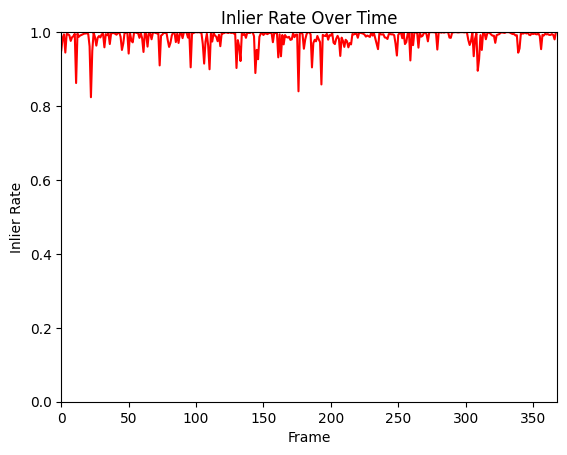

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# # inlier rates 예시 데이터
# inlier_rates = np.random.rand(368)  # 예시로 240개의 데이터를 랜덤으로 생성

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'r-', animated=True)

def init():
    ax.set_xlim(0, len(optical_flow_inlier_rates))  # 프레임 수에 따라 조절
    ax.set_ylim(0, 1)  # inlier rate의 최댓값에 따라 y축 범위 조절
    return ln,

def update(frame):
    xdata.append(frame)
    if stable_inlier_rates[frame] >= 0:
        ydata.append(optical_flow_inlier_rates[frame])
    else:
        ydata.append(1)
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(optical_flow_inlier_rates)),
                    init_func=init, blit=True, interval=(1000/30))

ani.save('Stable_inlier_rate_animation.gif', writer='pillow', fps=30)


plt.xlabel('Frame')
plt.ylabel('Inlier Rate')
plt.title('Inlier Rate Over Time')
plt.show()


## 동적 그래프 생성

/var/folders/gt/wdmlmv_d6jl1q6cvjxq5n_w00000gn/T/ipykernel_96288/799373486.py:26: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, len(frame_counts))  # You can adjust this based on your expected frame count


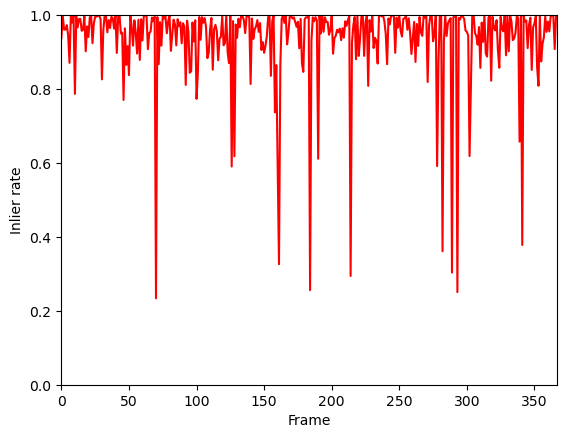

In [17]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.ion()  # Interactive mode on

inlier_rates_y = []
frame_counts = []

fig, ax = plt.subplots()
ax.set_xlabel('Frame')
ax.set_ylabel('Inlier rate')
ax.set_xlim(0, None)
ax.set_ylim(0, 1.0)
ln, = ax.plot([], [], 'r-', animated=True)

frame_count = 0

# Function to initialize the plot
def init():
    ax.set_xlim(0, 1)  # You can adjust this based on your expected frame count
    ax.set_ylim(0, 1.0)
    return ln,

# Function to update the plot
def update(frame):
    ax.set_xlim(0, len(frame_counts))  # You can adjust this based on your expected frame count
    ax.set_ylim(0, 1.0)
    
    if frame <= 0:
        inlier_rates_y.append(1)
        frame_counts.append(len(frame_counts))
    else:
        inlier_rates_y.append(frame)
        frame_counts.append(len(frame_counts))

    ln.set_data(frame_counts, inlier_rates_y)
    
    return ln,

# Assuming stable_inlier_rates is defined elsewhere in your code and contains the inlier rates
ani = FuncAnimation(fig, update, frames=stable_inlier_rates, init_func=init, blit=True, interval=len(stable_inlier_rates))

# Save the animation as a GIF
ani.save('Stable_inlier_rate_animation.gif', writer='pillow', fps=30)

plt.ioff()  # Interactive mode off
plt.show()


/var/folders/gt/wdmlmv_d6jl1q6cvjxq5n_w00000gn/T/ipykernel_96288/1218106592.py:26: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, len(frame_counts))  # You can adjust this based on your expected frame count


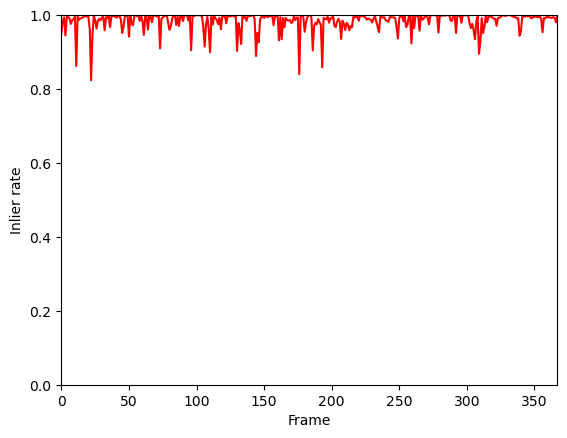

In [16]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.ion()  # Interactive mode on

inlier_rates_y = []
frame_counts = []

fig, ax = plt.subplots()
ax.set_xlabel('Frame')
ax.set_ylabel('Inlier rate')
ax.set_xlim(0, None)
ax.set_ylim(0, 1.0)
ln, = ax.plot([], [], 'r-', animated=True)

frame_count = 0

# Function to initialize the plot
def init():
    ax.set_xlim(0, 1)  # You can adjust this based on your expected frame count
    ax.set_ylim(0, 1.0)
    return ln,

# Function to update the plot
def update(frame):
    ax.set_xlim(0, len(frame_counts))  # You can adjust this based on your expected frame count
    ax.set_ylim(0, 1.0)
    
    if frame <= 0:
        inlier_rates_y.append(1)
        frame_counts.append(len(frame_counts))
    else:
        inlier_rates_y.append(frame)
        frame_counts.append(len(frame_counts))

    ln.set_data(frame_counts, inlier_rates_y)
    
    return ln,

# Assuming stable_inlier_rates is defined elsewhere in your code and contains the inlier rates
ani = FuncAnimation(fig, update, frames=optical_inlier_rates, init_func=init, blit=True, interval=len(optical_inlier_rates))

# Save the animation as a GIF
ani.save('Optical_inlier_rate_animation.gif', writer='pillow', fps=30)

plt.ioff()  # Interactive mode off
plt.show()
